In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="red">Session 4 Challenge:</font><br>Denoising Quantum Autoencoders

<table>
    <tr><td style="vertical-align: top;"><strong>Aim:</strong></td>
        <td>Create and test a quantum autoencoder (QAE) in PennyLane,<br>
            using time series data with the sliding window protocol.<br>
            Then understand the workings of pure quantum QAE.<br>
            Subsequently, implement a hybrid quantum-classical QAEs.<br>
            Finally, compare both models and their performance.<br>
            To facilitate manipulation of time series windows,<br>
            this notebook uses the provided "window.py" utility functions.
        </td></tr>
    <tr><td style="vertical-align: top;"><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td style="vertical-align: top;"><strong>Release:</strong></td>
        <td>September 2025</td></tr>
    <tr><td style="vertical-align: top;"><strong>Datasets</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included).<br>
            <table style="float: left;">
                <tr><td><em><strong>Mackie-Glass</strong></em></td><td>$\frac{dx(t)}{dt} = \frac{\beta x(t - \tau)}{1 + x(t - \tau)^n} - \gamma x(t)$</td></tr>
            </table>
        </td></tr>
    <tr><td style="vertical-align: top;"><strong>Challenge<br>Tasks:</strong></td>
        <td>Unlimited time</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at the end of this notebook):<br>
        <ol>
            <li>Explore the Mackie-Glass dataset with a sliding window protocol.</li>
            <li>Understand the pure quantum QAE implementation in PennyLane.</li>
            <li>Score the implemented pure quantum QAE on training and test partitions.</li>
            <li>Plot the history of training vs test scores.</li>
            <li>Rewrite the QAE from pure PennyLane to the PyTorch nn.Module framework.<br>
                Aim to have 3 classical layers, i.e. on input, at latent space, and on oputput.</li>
            <li>Test and compare pure quantum QAE vs. hybrid QAE performance.</li>
            <li>Improve the model performance.</li>
            <li>Generate 9 instances of differently initialised QAEs, score them and chart the results.</li>
            <li>Plot the data fit (example given) for the best, median and worst performing QAE.</li>
            <li>Reflect on this challenge.</li>
        </ol></td>
    </tr>
    <tr><td style="vertical-align: top;"><strong>References:</strong></td>
        <td><ul>
            <li>Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017.<br>
                <a href="https://iopscience.iop.org/article/10.1088/2058-9565/aa8072/ampdf" target="_blank">“Quantum Autoencoders for Efficient Compression of Quantum Data.”</a><br/>
                Quantum Science and Technology 2 (4): 045001.</li>
            <li>Bravo-Prieto, Carlos,<br>
                <a href="https://iopscience.iop.org/article/10.1088/2632-2153/ac0616/pdf" target="_blank">"Quantum autoencoders with enhanced data encoding."</a><br>
                Machine Learning: Science and Technology, 2, May 2021.</li>
            <li>Phillip Lippe, Tutorial 9: <a href="https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html" target="_blank">Deep Autoencoders</a>, UvA Deep Learning Tutorials, Fall 2022.</li>
            <li>Ali Shannon, <a href="https://github.com/techshot25/Autoencoders" target="_blank">"techshot25/Autoencoders"</a>, accessed March 12, 2024, GitHub.</li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the 
            <a href="https://www.gnu.org/licenses/gpl-3.0.en.html" target="_blank">GNU General Public License v3</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook</td></tr>
</table>

### Quantum Autoencoder (QAE)
In general, autoencoders (AE) are complex neural networks that feature lossy compression of input and recovery of the original data on ooutput.

Quantum autoencoders (QAE) are just quantum implementations of AEs.
In this exeercise, we will explore denoising QAEs, i.e. QAEs able to generate noise-free data on output, when given noisy data on input.
Denoising QAEs processing starts with the QAE encoder, which is responsible for input compression into a latent space that requires fewer qubits than those encoding input data.
The remaining qubits, called trash, will not be needed and will be reinitialised.
What follows is the QAE decoder, responsible fpr decompressing the latent space data into the form, which can be shown to preserve the most important or recurrent features of data on input.
What is lost in this process, via the trash space, is the less significant, noisy, or infrequently occurring data components.

Typical QAE applications include noise reduction from signals (e.g. audio, speech or medical recordings), time-series (e.g. financial or logistic data), and in restoration of images (e.g. old photographs) and videos (e.g. historical movie clips).

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl_test/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/site-packages',
 '.',
 '..']

## Libraries

In [3]:
import time
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from window import ts_add_noise, ts_wind_flatten_avg, ts_wind_make, ts_wind_split, ts_add_noise
from utilities import draw_circuit, meas_plot

## Utils

In [4]:
##### Random seed generator
def rand_seed():
    t=time.time(); t = int((t-int(t))*10000)
    return t

In [5]:
##### Data scaler
def scale_values(x, new_min=0, new_max=1):
    scaler = MinMaxScaler(feature_range=(new_min, new_max))
    return scaler.fit_transform(x.reshape(-1, 1)).flatten()

## <font color="blue">Very very long data preparation</font>
<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### The "mackey_glass" time series generator

The generator is based on the differential equation:<br><br>
$\frac{dx(t)}{dt} = \frac{\beta x(t - \tau)}{1 + x(t - \tau)^n} - \gamma x(t)$<br><br>
whith symbols relating to the following Python code variables:
<ul>
    <li>
        <b>$\frac{dx(t)}{dt}$</b>: The rate of change of the variable $x$ with respect to time $t$ (variable <code>dx</code>).
    </li>
    <li>
        <b>$x(t)$</b>: The value of the series at the current time $t$ (variables <code>xt</code> / <code>x[t]</code>).
    </li>
    <li>
        <b>$x(t - \tau)$</b>: The value of the series at a past time, delayed by $\tau$ (variables <code>xt_tau</code> / <code>x[t - tau]</code>).
    </li>
    <li>
        <b>$\beta$</b>: This term controls the production rate (parameter <code>beta</code>. ).
    </li>
    <li>
        <b>$\gamma$</b>: This represents a decay or loss rate (parameter <code>gamma</code>).
    </li>
    <li>
        <b>$n$</b>: This exponent determines the non-linearity of the feedback (parameter <code>n</code>).
    </li>
    <li>
        <b>$\tau$</b>: The time delay (parameter <code>tau</code>).
    </li>
</ul>

In [6]:
### Mmackey-Glass settings
beta=0.17    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=30       # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2       # Initial condition
length=600   # Length of the generated series 

### Data encoding setting
X_from = 0
X_to =   2*np.pi

y_margin = 0.1
y_low = 0+y_margin
y_high = 1-y_margin

In [7]:
### Simulates the Mackey-Glass time series
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate the Mackey-Glass time series
y_raw = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
y_raw = scale_values(y_raw, new_min=y_low, new_max=y_high)
y = y_raw[2::4] # reduce the number of points but keep the shape
X_raw = np.array([i for i in range(len(y))]) # Number points
X = scale_values(X_raw, new_min=X_from, new_max=X_to) # Keep the original coords

n_samples = len(y)

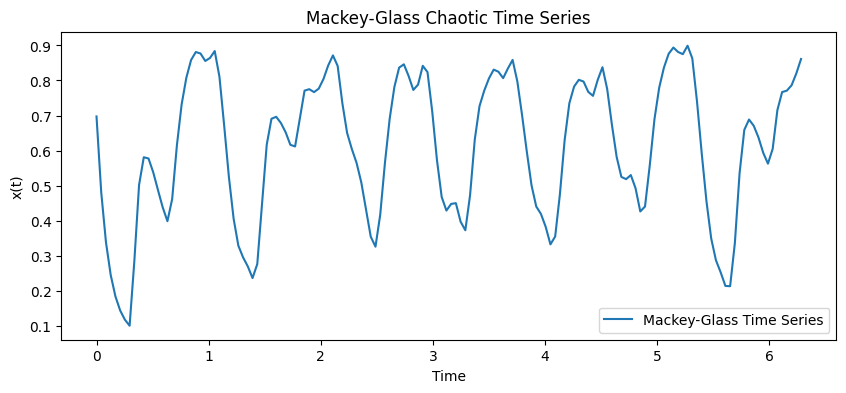

In [8]:
### Plot the Mackey-Glass time series
plt.figure(figsize=(10, 4))
plt.plot(X, y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions
*Note that QAE X and y will be the same (unless noise is injected into X).*<br>
*Also note that initially separate noisy partitions have been generated for visualisation only.*<br>
*In training, different noise is created at each training iteration.*<br>
*This is necessary to prevent QAE to learn the noisy signal itself.*

In [9]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, seed=0):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=False,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [10]:
### Data settings
split = 2/3

### Window settings
wind_size = 5
wind_step = 2
horizon = 1
noise = 0.2

### Random seed(s)
seed = 2024

In [11]:
from pprint import pprint

### Create windows and split into training and test partitions
X_train_coords, y_train_coords, X_test_coords, y_test_coords = \
        create_sw_tens(X, X, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
X_train_tens, y_train_tens, X_test_tens, y_test_tens = \
    create_sw_tens(y, y, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
_, X_train_noisy_tens, _, X_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)

### Find partition sizes
n_train = len(X_train_tens)
n_test = len(X_test_tens)

### Print a sample of data
print('\nSample of training partition:\n\nWindow coordinates:')
pprint(X_train_coords[0:3])
print('\nWindow values:')
pprint(X_train_tens[0:3]); 
print('\nSample of test partition:\n\nWindow coordinates:')
pprint(X_test_coords[0:3])
print('\nWindow values:')
pprint(X_test_tens[0:3]); print()


Sample of training partition:

Window coordinates:
tensor([[0.        , 0.04216903, 0.08433806, 0.12650709, 0.16867612],
        [0.08433806, 0.12650709, 0.16867612, 0.21084514, 0.25301417],
        [0.16867612, 0.21084514, 0.25301417, 0.2951832 , 0.33735223]], requires_grad=False)

Window values:
tensor([[0.69734564, 0.48057377, 0.33834975, 0.24503656, 0.18381379],
        [0.33834975, 0.24503656, 0.18381379, 0.14364552, 0.11729112],
        [0.18381379, 0.14364552, 0.11729112, 0.1       , 0.28394901]], requires_grad=False)

Sample of test partition:

Window coordinates:
tensor([[4.13256483, 4.17473386, 4.21690289, 4.25907192, 4.30124095],
        [4.21690289, 4.25907192, 4.30124095, 4.34340998, 4.38557901],
        [4.30124095, 4.34340998, 4.38557901, 4.42774804, 4.46991706]], requires_grad=False)

Window values:
tensor([[0.4750322 , 0.62933764, 0.73505152, 0.7825602 , 0.80183371],
        [0.73505152, 0.7825602 , 0.80183371, 0.7969696 , 0.76738859],
        [0.80183371, 0.7969696 ,

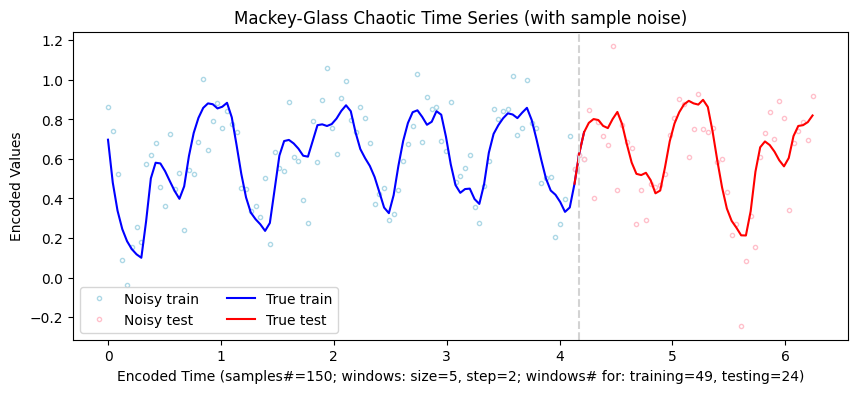

In [12]:
### Plot flattened window partitions

### Flatten windows by averaging overlapping data
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Plot partitions
plt.figure(figsize=(10, 4))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, label="Noisy train", color="lightblue", linestyle='', mfc='white', marker='.')
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, label="Noisy test", color="pink", linestyle='', mfc='white', marker='.')
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="blue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="red")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='--')
plt.xlabel(f'Encoded Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('Encoded Values')
plt.title('Mackey-Glass Chaotic Time Series (with sample noise)')
plt.legend(loc='best', ncol=2)
plt.show()

## <font color="blue">Model development</font>

### QAE hyper-parameters

In [13]:
### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 4
n_latent = 3
n_extra = 2
n_epochs = 100 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Debugging
debug_level = 2 # 0 - none, 1 - basic, 2 - full

### Simulator device

In [14]:
### Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

### Cost function

In [15]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

## Define, train and test a model
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Model creation

In [16]:
### Estimates the shape of the "half_qae_enc_with_swap"
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

In [17]:
### Full-QAE Circuit: Input + Encoder + Decoder + Output + No Swap Test
#   wires: list/array of wires to create a full QAE
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_extra: number of additional qubits to increase circuit breadth
#   n_layers: number of layers (repeats)
#   rot: rotation type, 'Ry' or 'Rxyz'
#   add_outseq: if True, the inverse of the input sequence will be added on output
#     If so, data needs to be split into input and output sequence
#   invert_dec: If True the decoder ansatz will be inverted
#   returns: QAE building function which takes arguments
#     inputs: list/array of input values to be angle encoded
#     weights: list/array of weights shaped to be used in ansatz blocks

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):

    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_latent+n_trash:]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    ### Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        n_wires = len(wires)
    
        for w in wires:
            # qml.Hadamard(wires=w)
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    ### Full QAE encoder
    def _full_qae(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        nonlocal latent_wires, trash_wires, extra_wires, data_wires, anz_wires
        nonlocal add_outseq, invert_dec
                
        n_anz_wires = n_latent + n_trash + n_extra 
        n_data = n_latent + n_trash
    
        # Add input encoder
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
    
        # Find encoder/decoder shapes
        #    This function assumes symmetric QAE so they are identical
        enc_weights_shape = _entangler_shape(n_layers, n_anz_wires, rot=rot)
        dec_weights_shape = enc_weights_shape
     
        # Split and shape weights for encoder and decoder ansatze
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Add encoder ansatz
        _entangler(anz_wires, enc_weights, rot=rot)        
      
        # Add initialisation of trash and extra space
        qml.Barrier(wires)
        for w in trash_wires: qml.measure(w, reset=True)
        for w in extra_wires: qml.measure(w, reset=True)
        qml.Barrier(wires)
    
        # Add decoder ansatz
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)
    
        # Add output sequence if needed
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)
            
        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]
        # return qml.probs(wires=data_wires)
    return _full_qae

In [18]:
%%script true
test_n_latent = 3; test_n_trash = 2; test_n_extra = 1; test_n_layers=2
test_n_inputs = test_n_latent + test_n_trash
test_n_wires = test_n_latent + test_n_trash + test_n_extra
test_wires = list(range(test_n_wires))
test_rot = 'Ry'

test_shape = full_qae_shape(test_n_latent, test_n_trash, test_n_extra, n_layers=test_n_layers, rot=test_rot)
test_n_weights = np.prod(test_shape)
print(f'Full-QAE shape: {test_shape}, weights: {int(test_n_weights)}\n')

test_data = np.linspace(100, 200, test_n_inputs, requires_grad=False)
test_weights = np.random.rand(*test_shape, requires_grad=True)

print(f'Data ({test_data.shape}): \n{test_data}\n')
print(f'Weights ({test_weights.shape}): \n{test_weights}\n')

In [19]:
%%script true
### Testing full-QAE for training

# Define a static full-QAE
test_qae = full_qae(test_wires, test_n_latent, test_n_trash, test_n_extra, n_layers=test_n_layers, rot=test_rot, add_outseq=True, invert_dec=True)

# Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
test_dev = qml.device(sim, wires=range(test_n_wires+test_n_trash+test_n_extra), shots=shots)
test_qae_qc = qml.QNode(test_qae, test_dev)
draw_circuit(test_qae_qc, scale=0.5, title='Full-QAE Decoder+Output', level='gradient') \
    (test_weights, test_data) # expansion_strategy='device'/'gradient'

In [20]:
%%script true
draw_circuit(test_qae_qc, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (test_weights, test_data) # expansion_strategy='device'/'gradient'

Full-QAE shape: (8, 7, 3), weights: 168



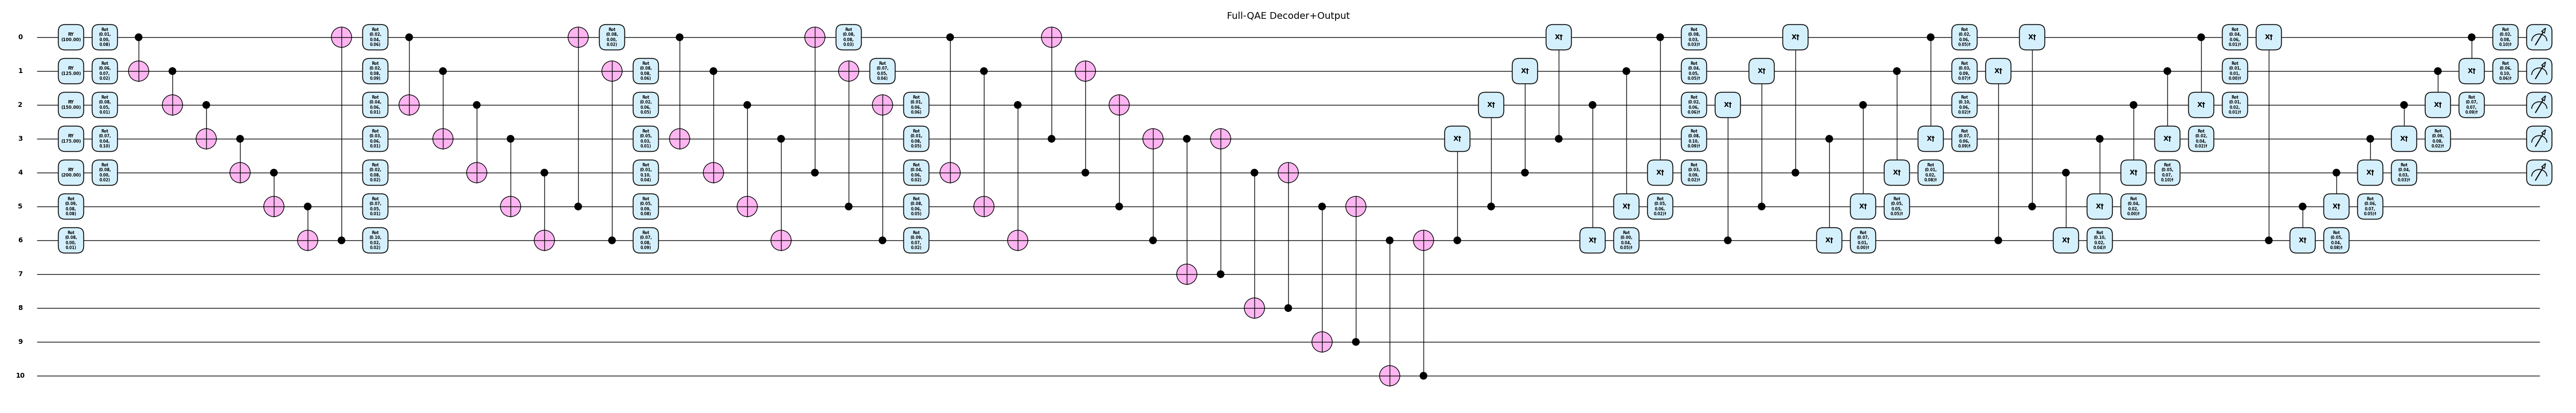

In [21]:
##### Create a model

wires = list(range(n_wires))

### Check the QAE shape
shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Full-QAE shape: {shape}, weights: {int(n_weights)}\n')

### Select the random initial parameters to match the ansatz shape
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_data, requires_grad=False)

qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)

# Create and draw a full-QAE
reserve_wires = n_trash+n_extra
dev = qml.device(sim, wires=n_wires+reserve_wires, shots=shots, seed=seed)
qae_model = qml.QNode(qae, dev)
draw_circuit(qae_model, scale=0.7, title='Full-QAE Decoder+Output', level='device') \
    (sample_params, sample_data) # expansion_strategy='device'/'gradient'

### Train the model

In [22]:
##### Training loop
def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1, scale_low=0, scale_high=2*np.pi):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, seed=seed+iter,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [23]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.05)

In [24]:
### Train the model
hist_cost, hist_params, init_weights, stats = train_with_noise(qae_model, 
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise, scale_low=y_low, scale_high=y_high,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed)

Iter: 000 (0003 sec) cost=0.209734
Iter: 010 (0039 sec) cost=0.041481
Iter: 020 (0075 sec) cost=0.021212
Iter: 030 (0110 sec) cost=0.015364
Iter: 040 (0146 sec) cost=0.017235
Iter: 050 (0182 sec) cost=0.013923
Iter: 060 (0217 sec) cost=0.014077
Iter: 070 (0253 sec) cost=0.013346
Iter: 080 (0288 sec) cost=0.012527
Iter: 090 (0324 sec) cost=0.012288

Training completed: epochs=100, min cost=0.010263 @ 76, time=356 secs



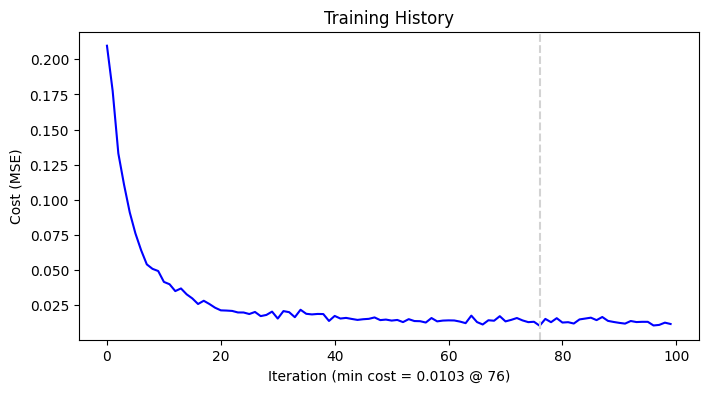

In [25]:
### Plot training cost

# Find the minimum cost
min_cost = np.min(hist_cost)
min_idx = np.argmin(hist_cost)

# Plot the chart
plt.figure(figsize=(8, 4))
plt.plot(hist_cost, label="Cost", color="blue")
plt.axvline(x=min_idx, color="lightgray", linestyle='dashed')
plt.xlabel(f'Iteration (min cost = {min_cost:0.4f} @ {min_idx})')
plt.ylabel('Cost (MSE)')
plt.title('Training History')
plt.show()

## Test the model

### Create an "optimum" model
*Note we have the parameters for all models developed in training.*<br>
*However, we have never scored these models, although, we really should have!*<br>
*Instead we selected the "best" model based on the training scores (actually - costs).*

In [26]:
### Create a test model and reconstruct data from noise (on best training MSE)
opt_params = hist_params[stats[0]]
wires = list(range(n_wires))
test_qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)
test_qae_model = qml.QNode(test_qae, dev)

In [27]:
### Reconstruct pure and noisy training TSs
pred_from_pure_train_tens = np.stack([qae_model(opt_params, x) for x in X_train_tens], requires_grad=False)
pred_from_pure_test_tens = np.stack([qae_model(opt_params, x) for x in X_test_tens], requires_grad=False)
pred_from_noisy_train_tens = np.stack([qae_model(opt_params, x) for x in X_train_noisy_tens], requires_grad=False)
pred_from_noisy_test_tens = np.stack([qae_model(opt_params, x) for x in X_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs
pred_from_pure_train_flat = ts_wind_flatten_avg(pred_from_pure_train_tens, wind_step)
pred_from_pure_test_flat = ts_wind_flatten_avg(pred_from_pure_test_tens, wind_step)
pred_from_noisy_train_flat = ts_wind_flatten_avg(pred_from_noisy_train_tens, wind_step)
pred_from_noisy_test_flat = ts_wind_flatten_avg(pred_from_noisy_test_tens, wind_step)

In [28]:
### Calculate metrics to show in charts
#   Note that all pure X = pure y, noise was injected into X only
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_noisy = mean_squared_error(X_train_flat_ts, X_train_noisy_flat_ts)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(X_train_flat_ts, pred_from_noisy_train_flat)
mse_test_pure_vs_noisy = mean_squared_error(X_test_flat_ts, X_test_noisy_flat_ts)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(X_test_flat_ts, pred_from_noisy_test_flat)

print(f'MSE train (pure vs noise) ~ (pure vs recovered) = {mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_noisy:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered) = {mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_noisy:0.4f}')

MSE train (pure vs noise) ~ (pure vs recovered) = 0.0199 ~ 0.0100
MSE test  (pure vs noise) ~ (pure vs recovered) = 0.0285 ~ 0.0087


### Compare pure data vs noisy and recovered data

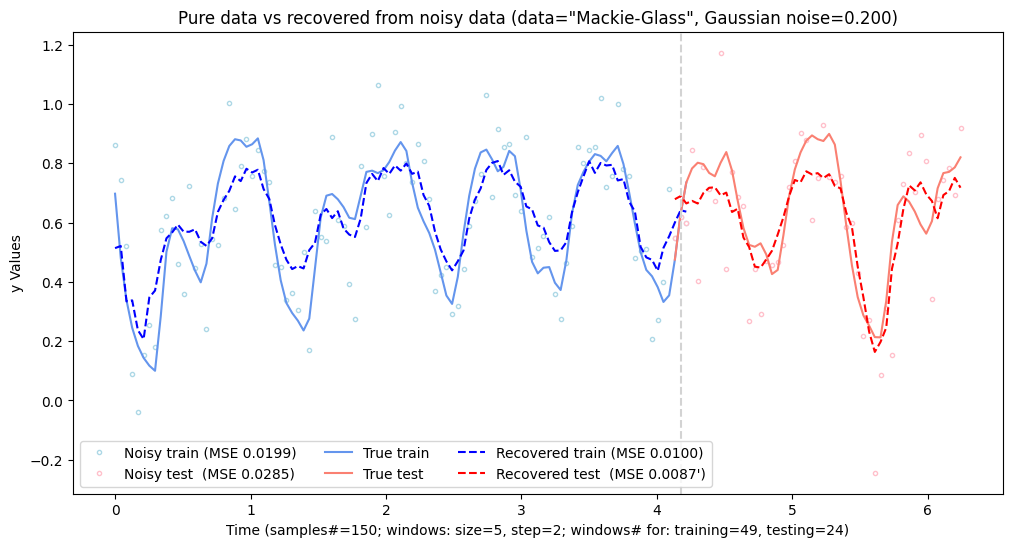

In [29]:
### Plot the original and recovered data with added performance metrics

# Prepare X, y lists for plotting
X_list = [X_train_flat_coords, X_test_flat_coords, 
          X_train_flat_coords, X_test_flat_coords, 
          X_train_flat_coords, X_test_flat_coords]
y_list = [X_train_noisy_flat_ts, X_test_noisy_flat_ts,
          X_train_flat_ts, X_test_flat_ts, 
          pred_from_noisy_train_flat, pred_from_noisy_test_flat]

# Plot partitions
print()
plt.figure(figsize=(12, 6))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="lightblue", linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="pink", linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_noisy_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_noisy:0.4f})")
plt.plot(X_test_flat_coords, pred_from_noisy_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_noisy:0.4f}')")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from noisy data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

## Write your observations here

- Observation 1:
- Observation 2:
- Observation 3:
- Observation 4:
- Observation 5:
- Observation 6:
- Observation 7:


# Software in use (Linux)

In [30]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.8.0
torchaudio                2.8.0
torcheval                 0.0.7
torchmetrics              1.8.2
torchsummary              1.5.1
torchvision               0.23.0
